In [24]:
from cnmodel import populations
from cnmodel.util import sound, random_seed
from cnmodel.protocols import Protocol
from collections import OrderedDict
import os, sys, time
import pickle
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from neuron import h
import multiprocessing as mp
from scipy.signal import savgol_filter
import yaml
import seaborn as sns
import itertools

In [2]:
sgc_pop = populations.SGC()
sgc_cfs = sgc_pop._get_cf_array(species='mouse')
b = (sgc_cfs[-1] - sgc_cfs[0]) / np.log(sgc_cfs[-1] / sgc_cfs[0])
a = sgc_cfs[0] - b * np.log(sgc_cfs[0])
sgc_cfs_log = a + b * np.log(sgc_cfs)

## Functions

In [40]:
def get_spontaneous_rate(cell_type, results, stimpar, pyr_ids=None):
    spont_spikes = []
    spont_times = []

    for stim, iterations in list(results.values()):
        rep_spont_spikes = []
        for cell, vec in iterations.items():
            if isinstance(cell, str):
                continue
            save_rate = True if (('sgc' in cell_type) or (('pyr' in cell_type) and (cell[1] in pyr_ids))) else False
            if (cell_type in cell[0]) and save_rate:
                spikes = np.array(vec[1])
                # if len(spikes) > 0:
                rep_spont_spikes.append(((spikes >= stimpar['baseline'][0]) * (spikes < stimpar['baseline'][1])).sum())
                # spont_times.append(stimpar['baseline'][1] - stimpar['baseline'][0])
        spont_spikes.append(rep_spont_spikes)

    spont_spikes = np.mean(spont_spikes, axis=0)

    spont_rates = np.array(spont_spikes) / (stimpar['baseline'][1] - stimpar['baseline'][0])
    return spont_rates

In [41]:
def get_cell_nspikes(cell_type, results, response, pyr_ids=None):
    n_spikes = []
    cell_ids = []

    for stim, iterations in results.values():
        rep_n_spikes = []
        rep_cell_ids = []
        for cell, vec in iterations.items():
            if isinstance(cell, str):
                continue
            save_rate = True if ('sgc' in cell_type) or (('pyr' in cell_type) and (cell[1] in pyr_ids)) else False
            if (cell_type in cell[0]) and save_rate:
                spikes = np.array(vec[1])
                num_spikes = ((spikes >= response[0]) & (spikes < response[1])).sum()
                rep_n_spikes.append(num_spikes)
                rep_cell_ids.append(cell[1])

        n_spikes.append(rep_n_spikes)
        cell_ids.append(rep_cell_ids)

    n_spikes = np.mean(n_spikes, axis=0)

    return cell_ids[0], np.array(n_spikes)

In [44]:
def get_cell_msfs(cell_type, results, response, pyr_ids=None):
    msfs = []
    cell_ids = []

    for stim, iterations in results.values():
        rep_msfs = []
        rep_cell_ids = []
        for cell, vec in iterations.items():
            if isinstance(cell, str):
                continue
            save_rate = True if ('sgc' in cell_type) or (('pyr' in cell_type) and (cell[1] in pyr_ids)) else False
            if (cell_type in cell[0]) and save_rate:
                spikes = np.array(vec[1])
                resp_spikes = spikes[(spikes >= response[0]) & (spikes < response[1])]
                num_spikes = len(resp_spikes)
                num_isi = num_spikes - 1 if num_spikes > 0 else 0
                msf = num_isi / (spikes[-1] - spikes[0]) * 1000 if num_spikes > 1 else 1
                rep_msfs.append(msf)
                rep_cell_ids.append(cell[1])

        msfs.append(rep_msfs)
        cell_ids.append(rep_cell_ids)

    msfs = np.average(msfs, axis=0)

    return cell_ids[0], np.array(msfs)

## Normal vs Loss - 22kHz at 60 dB

In [51]:
stimpar = {
    "dur": 0.26,
    "pip": 0.1,
    "start": [0.1],
    "baseline": [50, 100],
    "response": [100, 200],
}

input_freq = 22e3
input_level = 60

In [52]:
n_cfs = 665
n_reps = 2

sim_flag = 'network_longerstim'

results = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids = list(itertools.chain.from_iterable(pyr_ids_per_band.values()))
freqs = list(pyr_ids_per_band.keys())
pyr_spont_rates = get_spontaneous_rate('pyramidal', results, stimpar, pyr_ids)
sgc_spont_rates = get_spontaneous_rate('sgc', results, stimpar)
pyr_ids, pyr_resp_spikes = get_cell_nspikes('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_spikes = get_cell_nspikes('sgc', results, stimpar['response'])

pyr_ids, pyr_resp_msfs = get_cell_msfs('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_msfs = get_cell_msfs('sgc', results, stimpar['response'])

n_cfs = 665  # 213 or 665
loss_frac = 60
loss_version = 'm3'
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids_loss = list(itertools.chain.from_iterable(pyr_ids_per_band_loss.values()))
freqs_loss = list(pyr_ids_per_band_loss.keys())
pyr_spont_rates_loss = get_spontaneous_rate('pyramidal', results_loss, stimpar, pyr_ids_loss)
sgc_spont_rates_loss = get_spontaneous_rate('sgc', results_loss, stimpar)
pyr_ids_loss, pyr_resp_spikes_loss = get_cell_nspikes('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_spikes_loss = get_cell_nspikes('sgc', results_loss, stimpar['response'])

pyr_ids_loss, pyr_resp_msfs_loss = get_cell_msfs('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_msfs_loss = get_cell_msfs('sgc', results_loss, stimpar['response'])

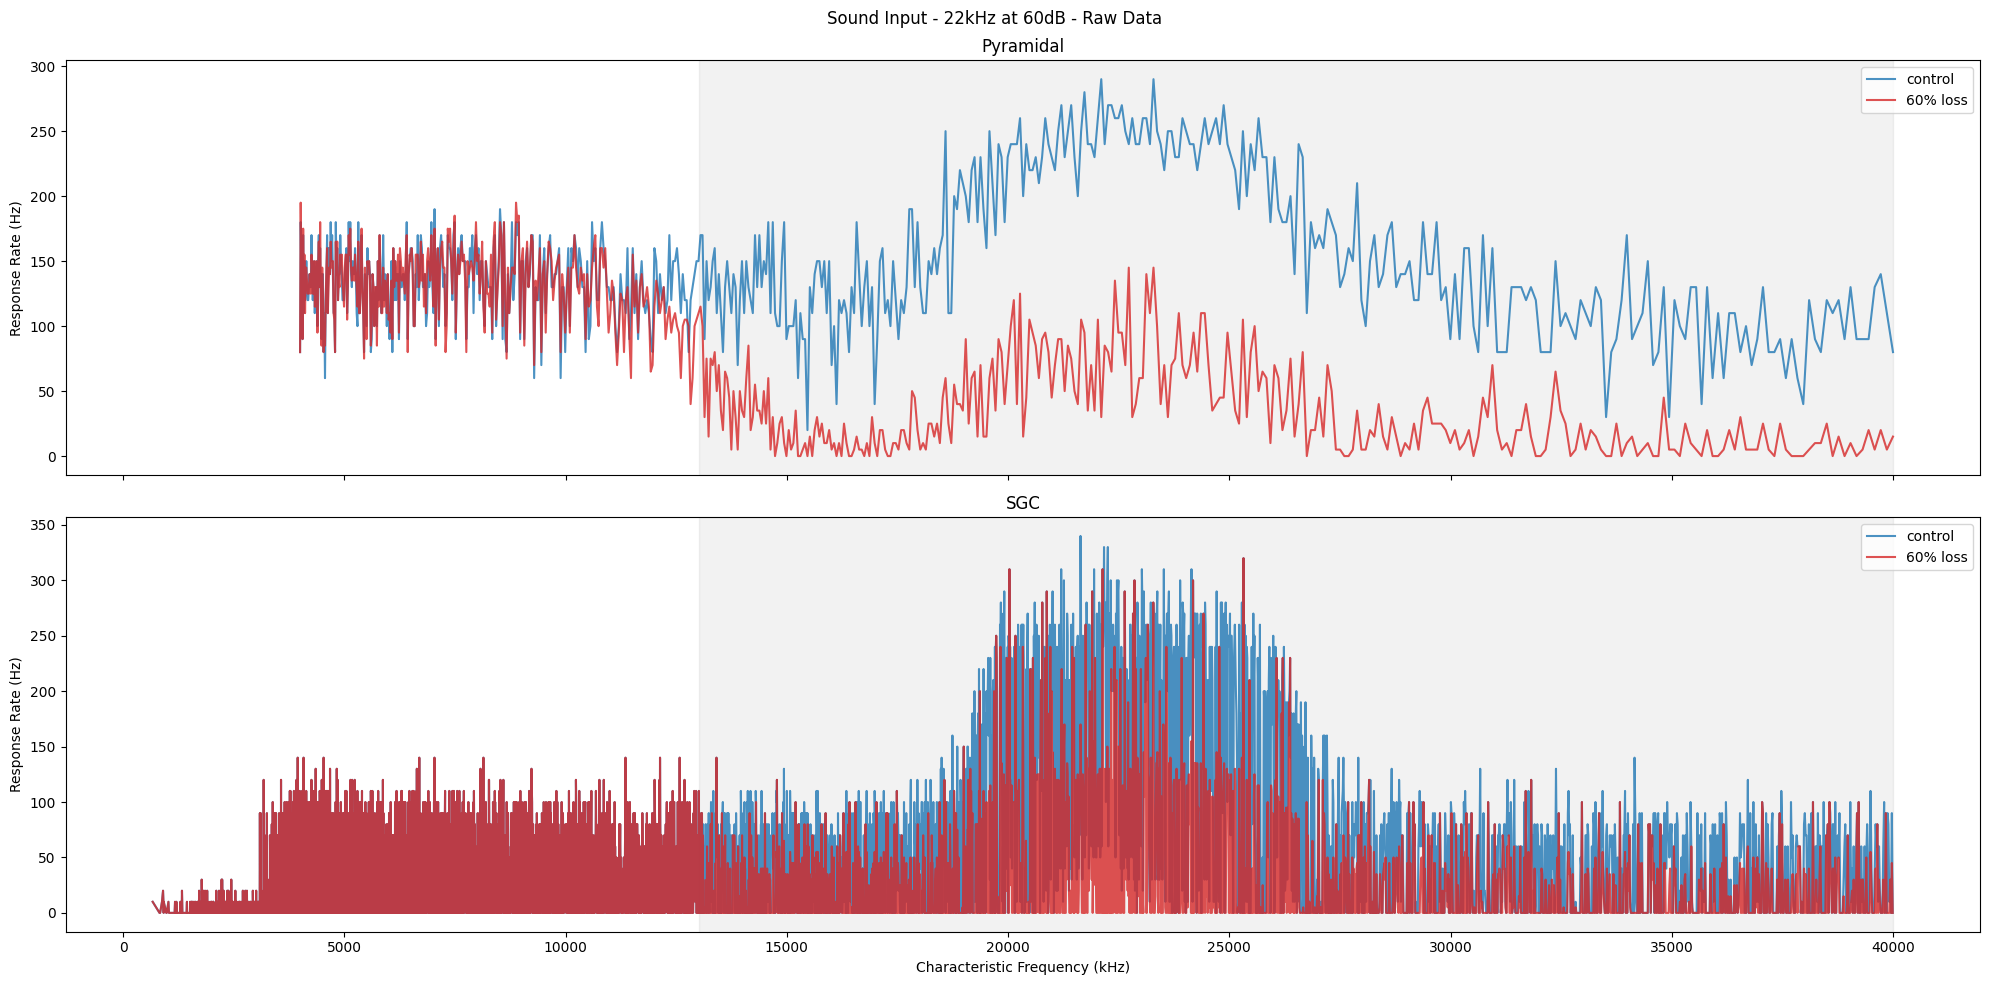

In [53]:
fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)  #, sharey=True)
axs = axs.ravel()

data = (sgc_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates*0
# data = sgc_resp_msfs
axs[1].plot(sgc_cfs[sgc_ids], data, color='tab:blue', zorder=13, alpha=0.8, label='control')
axs[1].set_title('SGC (control)')

data = (sgc_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates_loss*0 
# data = sgc_resp_msfs_loss
axs[1].plot(sgc_cfs[sgc_ids_loss], data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[1].set_title(f"SGC")

data = (pyr_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates*0 
# data = pyr_resp_msfs
axs[0].plot(freqs, data, color='tab:blue', zorder=13, alpha=0.8, label='control')

data = (pyr_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates_loss*0 
# data = pyr_resp_msfs_loss
axs[0].plot(freqs_loss, data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[0].set_title(f'Pyramidal')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Response Rate (Hz)')
axs[1].set_ylabel('Response Rate (Hz)')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB - Raw Data")
fig.tight_layout()

## Normal vs Loss with Dstellate -> Vertical - 22kHz at 60 dB

In [9]:
stimpar = {
    "dur": 0.26,
    "pip": 0.1,
    "start": [0.1],
    "baseline": [50, 100],
    "response": [100, 200],
}

input_freq = 22e3
input_level = 60

In [49]:
n_cfs = 665
n_reps = 2

sim_flag = 'network_ds2v'

results = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids = list(itertools.chain.from_iterable(pyr_ids_per_band.values()))
freqs = list(pyr_ids_per_band.keys())
pyr_spont_rates = get_spontaneous_rate('pyramidal', results, stimpar, pyr_ids)
sgc_spont_rates = get_spontaneous_rate('sgc', results, stimpar)
pyr_ids, pyr_resp_spikes = get_cell_nspikes('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_spikes = get_cell_nspikes('sgc', results, stimpar['response'])

pyr_ids, pyr_resp_msfs = get_cell_msfs('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_msfs = get_cell_msfs('sgc', results, stimpar['response'])

n_cfs = 665  # 213 or 665
loss_frac = 60
loss_version = 'm3'
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids_loss = list(itertools.chain.from_iterable(pyr_ids_per_band_loss.values()))
freqs_loss = list(pyr_ids_per_band_loss.keys())
pyr_spont_rates_loss = get_spontaneous_rate('pyramidal', results_loss, stimpar, pyr_ids_loss)
sgc_spont_rates_loss = get_spontaneous_rate('sgc', results_loss, stimpar)
pyr_ids_loss, pyr_resp_spikes_loss = get_cell_nspikes('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_spikes_loss = get_cell_nspikes('sgc', results_loss, stimpar['response'])

pyr_ids_loss, pyr_resp_msfs_loss = get_cell_msfs('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_msfs_loss = get_cell_msfs('sgc', results_loss, stimpar['response'])

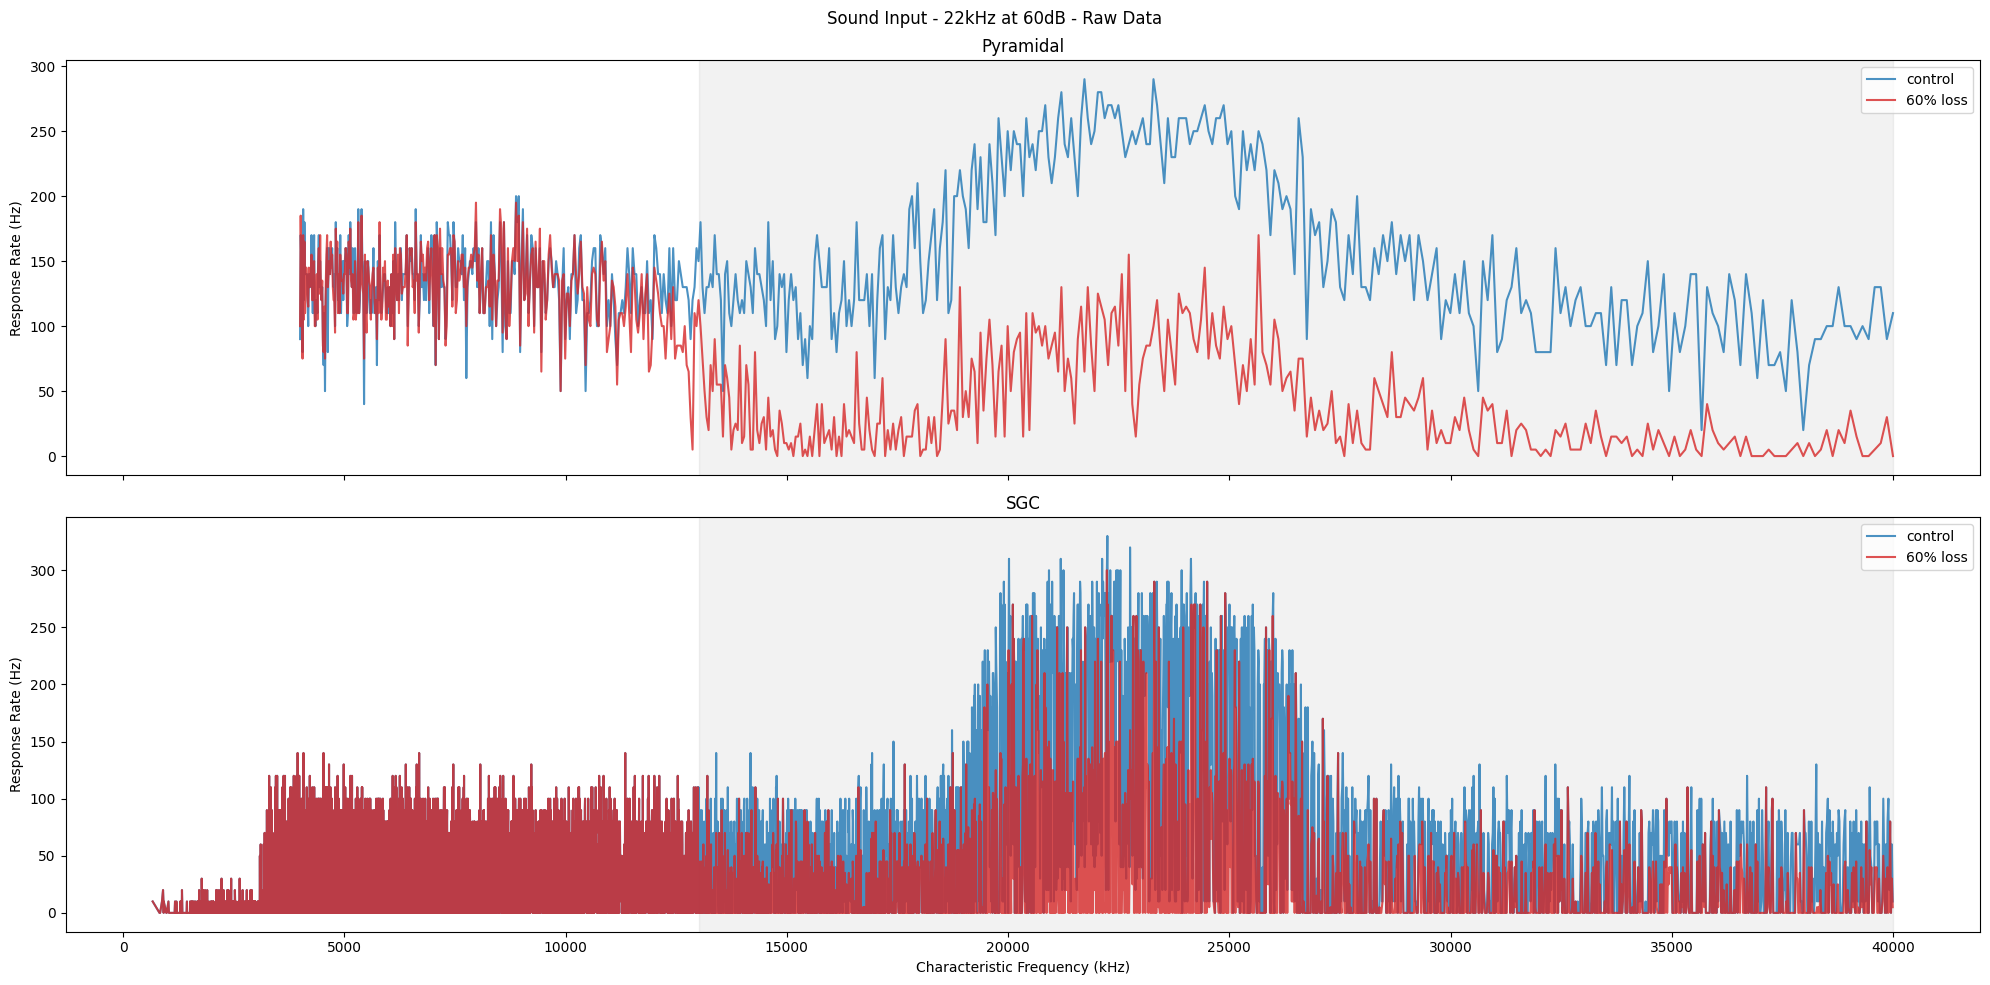

In [50]:
fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)  #, sharey=True)
axs = axs.ravel()

data = (sgc_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates*0
# data = sgc_resp_msfs
axs[1].plot(sgc_cfs[sgc_ids], data, color='tab:blue', zorder=13, alpha=0.8, label='control')
axs[1].set_title('SGC (control)')

data = (sgc_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates_loss*0 
# data = sgc_resp_msfs_loss
axs[1].plot(sgc_cfs[sgc_ids_loss], data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[1].set_title(f"SGC")

data = (pyr_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates*0 
# data = pyr_resp_msfs
axs[0].plot(freqs, data, color='tab:blue', zorder=13, alpha=0.8, label='control')

data = (pyr_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates_loss*0 
# data = pyr_resp_msfs_loss
axs[0].plot(freqs_loss, data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[0].set_title(f'Pyramidal')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Response Rate (Hz)')
axs[1].set_ylabel('Response Rate (Hz)')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB - Raw Data")
fig.tight_layout()

## Normal vs Loss with IC - 22kHz at 60dB

In [12]:
stimpar = {
    "dur": 0.26,
    "pip": 0.1,
    "start": [0.1],
    "baseline": [50, 100],
    "response": [100, 200],
}

input_freq = 22e3
input_level = 60

In [45]:
n_cfs = 665
n_reps = 2

sim_flag = 'network_ds2v'

results = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_ic/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_ic/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids = list(itertools.chain.from_iterable(pyr_ids_per_band.values()))
freqs = list(pyr_ids_per_band.keys())
pyr_spont_rates = get_spontaneous_rate('pyramidal', results, stimpar, pyr_ids)
sgc_spont_rates = get_spontaneous_rate('sgc', results, stimpar)
pyr_ids, pyr_resp_spikes = get_cell_nspikes('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_spikes = get_cell_nspikes('sgc', results, stimpar['response'])

pyr_ids, pyr_resp_msfs = get_cell_msfs('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_msfs = get_cell_msfs('sgc', results, stimpar['response'])

n_cfs = 665  # 213 or 665
loss_frac = 60
loss_version = 'm3'
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}_ic/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}_ic/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids_loss = list(itertools.chain.from_iterable(pyr_ids_per_band_loss.values()))
freqs_loss = list(pyr_ids_per_band_loss.keys())
pyr_spont_rates_loss = get_spontaneous_rate('pyramidal', results_loss, stimpar, pyr_ids_loss)
sgc_spont_rates_loss = get_spontaneous_rate('sgc', results_loss, stimpar)
pyr_ids_loss, pyr_resp_spikes_loss = get_cell_nspikes('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_spikes_loss = get_cell_nspikes('sgc', results_loss, stimpar['response'])

pyr_ids_loss, pyr_resp_msfs_loss = get_cell_msfs('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_msfs_loss = get_cell_msfs('sgc', results_loss, stimpar['response'])

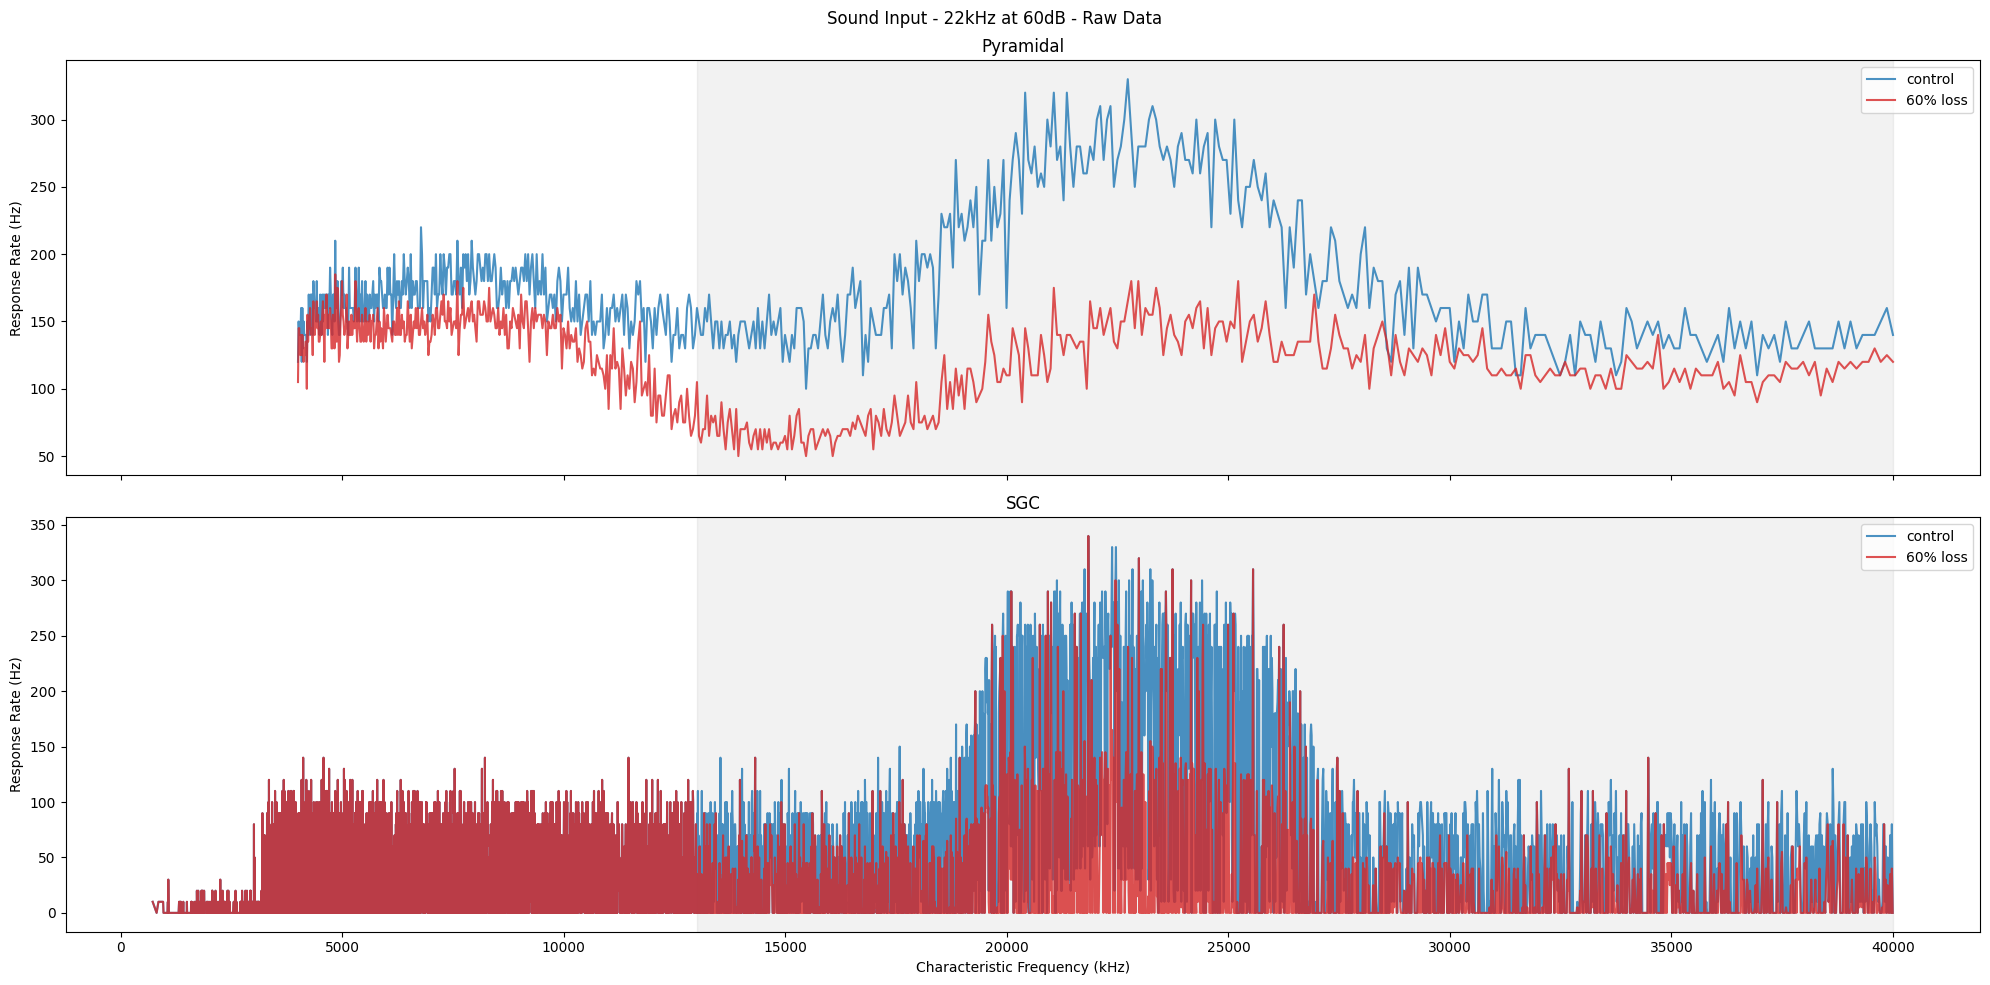

In [47]:
fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)  #, sharey=True)
axs = axs.ravel()

data = (sgc_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates*0
# data = sgc_resp_msfs
axs[1].plot(sgc_cfs[sgc_ids], data, color='tab:blue', zorder=13, alpha=0.8, label='control')
axs[1].set_title('SGC (control)')

data = (sgc_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates_loss*0 
# data = sgc_resp_msfs_loss
axs[1].plot(sgc_cfs[sgc_ids_loss], data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[1].set_title(f"SGC")

data = (pyr_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates*0 
# data = pyr_resp_msfs
axs[0].plot(freqs, data, color='tab:blue', zorder=13, alpha=0.8, label='control')

data = (pyr_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates_loss*0 
# data = pyr_resp_msfs_loss
axs[0].plot(freqs_loss, data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[0].set_title(f'Pyramidal')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Response Rate (Hz)')
axs[1].set_ylabel('Response Rate (Hz)')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB - Raw Data")
fig.tight_layout()